###Importing pyspark and related libraries

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql.functions import desc, col, array, explode, struct, lit
import pyspark.sql.functions as psf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DateType
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

###Declaring Spark context and spark session objects

In [ ]:
#Declaring Spark context and spark session objects
from pyspark import SparkContext
sc= SparkContext("local","project context");
sc.setLogLevel("Error")
spark = SparkSession(sc)

**Importing data and Removing null values**

In [ ]:
#Removing null values

#covidData = spark.read.option("inferSchema","true").option("header","true").csv("time_series_19-covid-Confirmed_archived_0325.csv")
covidData = spark.read.option("inferSchema","true").option("header","true").csv("/content/drive/My Drive/Colab Notebooks/BigData/time_series_19-covid-Confirmed_archived_0325.csv")
beforeClean =covidData.count()

covidData = covidData.na.drop("any")
print(beforeClean)
print(covidData.count())
print("Null rows removed: " + str(beforeClean - covidData.count()))
covidData.show(10)

501
135
Null rows removed: 366
+--------------------+--------------+--------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Province/State|Country/Region|     Lat|     Long|1/22/20|1/23/20|1/24/20|1/25/20|1/26/20|1/27/20|1/28/20|1/29/20|1/30/20|1/31/20|2/1/20|2/2/20|2/3/20|2/4/20|2/5/20|2/6/20|2/7/20|2/8/20|2/9/20|2/10/20|2/11/20|2/12/20|2/13/20|2/14/20|2/15/20|2/16/20|2/17/20|2/18/20|2/19/20|2/20/20|2/21/20|2/22/20|2/23/20|2/24/20|2/25/20|2/26/20|2/27/20|2/28/20|2/29/20|3/1/20|3/2/20|3/3/20|3/4/20|3/5/20|3/6/20|3/7/20|3/8/20|3/9/20|3/10/20|3/11

**Filter by country Australia**

In [ ]:
#Filter by Australia
covid_aus_data= covidData.filter(col("Country/Region")=="Australia")
covid_aus_data.show(10)

+--------------------+--------------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Province/State|Country/Region|     Lat|    Long|1/22/20|1/23/20|1/24/20|1/25/20|1/26/20|1/27/20|1/28/20|1/29/20|1/30/20|1/31/20|2/1/20|2/2/20|2/3/20|2/4/20|2/5/20|2/6/20|2/7/20|2/8/20|2/9/20|2/10/20|2/11/20|2/12/20|2/13/20|2/14/20|2/15/20|2/16/20|2/17/20|2/18/20|2/19/20|2/20/20|2/21/20|2/22/20|2/23/20|2/24/20|2/25/20|2/26/20|2/27/20|2/28/20|2/29/20|3/1/20|3/2/20|3/3/20|3/4/20|3/5/20|3/6/20|3/7/20|3/8/20|3/9/20|3/10/20|3/11/20|3/12/20|3/13/20|3/14/20|3/15/

**Merging all states**

In [ ]:
exprs = {x: "sum" for x in covid_aus_data.columns if x not in ['Country/Region','Province/State','Lat','Long','1/22/20','1/23/20','1/24/20','1/25/20','1/26/20','1/27/20','1/28/20','1/29/20','1/30/20','1/31/20']}
covid_aus_data = covid_aus_data.groupBy("Country/Region").agg(exprs)
covid_aus_data.show()

+--------------+------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----------+-----------+------------+------------+-----------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+-----------+------------+-----------+------------+-----------+------------+-----------+------------+------------+-----------+------------+------------+------------+------------+------------+
|Country/Region|sum(3/19/20)|sum(3/9/20)|sum(3/7/20)|sum(3/2/20)|sum(2/2/20)|sum(3/23/20)|sum(2/24/20)|sum(2/22/20)|sum(2/26/20)|sum(2/9/20)|sum(2/3/20)|sum(3/18/20)|sum(3/21/20)|sum(3/1/20)|sum(2/14/20)|sum(2/8/20)|sum(2/16/20)|sum(3/17/20)|sum(2/15/20)|sum(2/13/20)|sum(3/6/20)|sum(3/15/20)|sum(3/20/20)|sum(2/23/20)|sum(3/

**Renaming column dates to their original dates**

In [ ]:
def clean_df_names(df):
    l = df.columns
    cols = [c.replace('sum(','').replace(')','').strip() for c in l]
    return df.toDF(*cols)

data = clean_df_names(covid_aus_data)
data = data.drop('Country/Region')
data = data.select(sorted(data.columns))
data.show()

+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+------+------+------+------+------+------+------+
|2/1/20|2/10/20|2/11/20|2/12/20|2/13/20|2/14/20|2/15/20|2/16/20|2/17/20|2/18/20|2/19/20|2/2/20|2/20/20|2/21/20|2/22/20|2/23/20|2/24/20|2/25/20|2/26/20|2/27/20|2/28/20|2/29/20|2/3/20|2/4/20|2/5/20|2/6/20|2/7/20|2/8/20|2/9/20|3/1/20|3/10/20|3/11/20|3/12/20|3/13/20|3/14/20|3/15/20|3/16/20|3/17/20|3/18/20|3/19/20|3/2/20|3/20/20|3/21/20|3/22/20|3/23/20|3/3/20|3/4/20|3/5/20|3/6/20|3/7/20|3/8/20|3/9/20|
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+----

**Converting columns to rows with index and sorting**



In [ ]:
def to_long(df):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes))

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("key"), col(c).alias("label")) for c in cols
    ])).alias("kvs")

    return df.select([kvs]).select(["kvs.key", "kvs.label"])

data_temp = to_long(data)
data_temp.show()

+-------+-----+
|    key|label|
+-------+-----+
| 2/1/20|   12|
|2/10/20|   15|
|2/11/20|   15|
|2/12/20|   15|
|2/13/20|   15|
|2/14/20|   15|
|2/15/20|   15|
|2/16/20|   15|
|2/17/20|   15|
|2/18/20|   15|
|2/19/20|   15|
| 2/2/20|   12|
|2/20/20|   15|
|2/21/20|   19|
|2/22/20|   22|
|2/23/20|   22|
|2/24/20|   22|
|2/25/20|   22|
|2/26/20|   22|
|2/27/20|   23|
+-------+-----+
only showing top 20 rows



In [ ]:
#creating a temp view and converting date to date format
data_temp.createOrReplaceTempView("infected_Data")
data_con = spark.sql("""
  SELECT TO_DATE(CAST(UNIX_TIMESTAMP(key, 'MM/dd/yy') AS TIMESTAMP)) AS Formatted_Date,
  label from infected_Data  ORDER BY Formatted_Date"""
)
data_con.printSchema()

#adding index column (from 1 to len(data_con))
window = Window.orderBy(psf.col('Formatted_Date'))
data_final = data_con.withColumn('val', psf.row_number().over(window))

data_arima = data_final.toPandas()
data_final.show()

root
 |-- Formatted_Date: date (nullable = true)
 |-- label: long (nullable = true)

+--------------+-----+---+
|Formatted_Date|label|val|
+--------------+-----+---+
|    2020-02-01|   12|  1|
|    2020-02-02|   12|  2|
|    2020-02-03|   12|  3|
|    2020-02-04|   13|  4|
|    2020-02-05|   13|  5|
|    2020-02-06|   14|  6|
|    2020-02-07|   15|  7|
|    2020-02-08|   15|  8|
|    2020-02-09|   15|  9|
|    2020-02-10|   15| 10|
|    2020-02-11|   15| 11|
|    2020-02-12|   15| 12|
|    2020-02-13|   15| 13|
|    2020-02-14|   15| 14|
|    2020-02-15|   15| 15|
|    2020-02-16|   15| 16|
|    2020-02-17|   15| 17|
|    2020-02-18|   15| 18|
|    2020-02-19|   15| 19|
|    2020-02-20|   15| 20|
+--------------+-----+---+
only showing top 20 rows



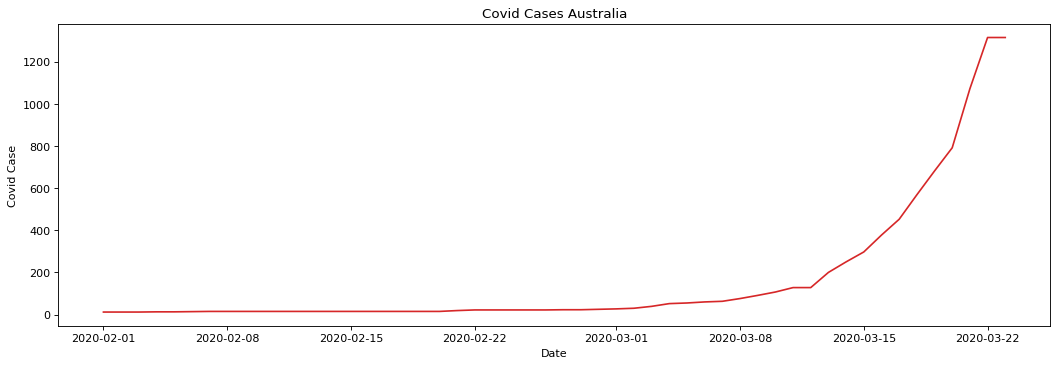

In [ ]:
import matplotlib.pyplot as plt

df = data_final.toPandas()

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Covid Case', dpi=80):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Formatted_Date, y=df.label, title='Covid Cases Australia')    


**Removing 22nd and 23rd march data from dataset**

In [ ]:
#creating data frame with 22nd and 23rd march data.
evaluation_data = data_final.where(data_final.Formatted_Date.isin('2020-03-22', '2020-03-23'))
evaluation_data.show()

#Removing 22nd and 23rd march data from data_final.
data_final = data_final.where(~data_final.Formatted_Date.isin('2020-03-22', '2020-03-23'))
data_final.show()

+--------------+-----+---+
|Formatted_Date|label|val|
+--------------+-----+---+
|    2020-03-22| 1314| 51|
|    2020-03-23| 1314| 52|
+--------------+-----+---+

+--------------+-----+---+
|Formatted_Date|label|val|
+--------------+-----+---+
|    2020-02-01|   12|  1|
|    2020-02-02|   12|  2|
|    2020-02-03|   12|  3|
|    2020-02-04|   13|  4|
|    2020-02-05|   13|  5|
|    2020-02-06|   14|  6|
|    2020-02-07|   15|  7|
|    2020-02-08|   15|  8|
|    2020-02-09|   15|  9|
|    2020-02-10|   15| 10|
|    2020-02-11|   15| 11|
|    2020-02-12|   15| 12|
|    2020-02-13|   15| 13|
|    2020-02-14|   15| 14|
|    2020-02-15|   15| 15|
|    2020-02-16|   15| 16|
|    2020-02-17|   15| 17|
|    2020-02-18|   15| 18|
|    2020-02-19|   15| 19|
|    2020-02-20|   15| 20|
+--------------+-----+---+
only showing top 20 rows



In [ ]:
#creating a features column with input (val variable) for the regression model
vectorAssembler = VectorAssembler(inputCols = ['val'], outputCol = 'features')
#vectorAssembler = VectorAssembler(inputCols = ['label'], outputCol = 'features')
vdata_final = vectorAssembler.transform(data_final)
#vdata_final = vdata_final.selectExpr("val as label", "features as features")
vdata_final.show()

+--------------+-----+---+--------+
|Formatted_Date|label|val|features|
+--------------+-----+---+--------+
|    2020-02-01|   12|  1|   [1.0]|
|    2020-02-02|   12|  2|   [2.0]|
|    2020-02-03|   12|  3|   [3.0]|
|    2020-02-04|   13|  4|   [4.0]|
|    2020-02-05|   13|  5|   [5.0]|
|    2020-02-06|   14|  6|   [6.0]|
|    2020-02-07|   15|  7|   [7.0]|
|    2020-02-08|   15|  8|   [8.0]|
|    2020-02-09|   15|  9|   [9.0]|
|    2020-02-10|   15| 10|  [10.0]|
|    2020-02-11|   15| 11|  [11.0]|
|    2020-02-12|   15| 12|  [12.0]|
|    2020-02-13|   15| 13|  [13.0]|
|    2020-02-14|   15| 14|  [14.0]|
|    2020-02-15|   15| 15|  [15.0]|
|    2020-02-16|   15| 16|  [16.0]|
|    2020-02-17|   15| 17|  [17.0]|
|    2020-02-18|   15| 18|  [18.0]|
|    2020-02-19|   15| 19|  [19.0]|
|    2020-02-20|   15| 20|  [20.0]|
+--------------+-----+---+--------+
only showing top 20 rows



## Model 1:- Linear regression


In [ ]:
#finding the best parameters and choosing the model with these parameters

evaluator = RegressionEvaluator(metricName="mae")
training = vdata_final.select('label', 'features') #choosing training data
lr = LinearRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [50, 100, 200, 300, 400, 500]) \
                                .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
                                .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, \
                        evaluator=evaluator, numFolds=3) #cross validator to choose the best parameters for the model
lrModel = lr_cv.fit(training) #train the model
bestModel = lrModel.bestModel #choose the best model
print('Best Param (regParam): ', bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())
trainingSummary = bestModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError) #rmse of training data
print("r2: %f" % trainingSummary.r2) #how much our model explains

Best Param (regParam):  1.0
Best Param (MaxIter):  50
Best Param (elasticNetParam):  1.0
RMSE: 163.474403
r2: 0.455187


###Prediction for date 22/03 and 23/03

In [ ]:
test_data = vectorAssembler.transform(evaluation_data)
predictions = bestModel.transform(test_data)
predictions.select("prediction","features", "label").show()

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % evaluator.evaluate(predictions))

+------------------+--------+-----+
|        prediction|features|label|
+------------------+--------+-----+
| 382.8582608543268|  [51.0]| 1314|
|393.14368284861416|  [52.0]| 1314|
+------------------+--------+-----+

RMSE on test data = 926.013


## Model 2:-Regression with log transformation

The dataset of Covid 19 epidemic has exponential characteristic. 
The reason to use Exponential Growth for modeling the Coronavirus outbreak is that epidemiologists have studied those types of outbreaks and it is well known that the first period of an epidemic follows Exponential Growth.

source : https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f

In [ ]:
from pyspark.sql.functions import log
log_data = vdata_final.withColumn("label", log(col("label")))

log_training = log_data.select(['features', 'label'])

evaluator = RegressionEvaluator(metricName="mae")
lr = LinearRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [50, 100, 200, 300, 400, 500]) \
                                .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
                                .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, \
                        evaluator=evaluator, numFolds=3) #cross validator to choose the best parameters for the model
lrModel = lr_cv.fit(log_training) #train the model
bestModel = lrModel.bestModel #choose the best model
print('Best Param (regParam): ', bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())
trainingSummary = bestModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError) #rmse of training data
print("r2: %f" % trainingSummary.r2) #how much our model explains

Best Param (regParam):  0.1
Best Param (MaxIter):  50
Best Param (elasticNetParam):  1.0
RMSE: 0.559567
r2: 0.817510


###Prediction of 22/03 and 23/03 after log transformation

In [ ]:

test_data = vectorAssembler.transform(evaluation_data.withColumn("label", log(col("label"))))
predictions = bestModel.transform(test_data)
predictions.select("prediction","features", "label").show()

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % evaluator.evaluate(predictions))

# evaluator = RegressionEvaluator(predictionCol="prediction", \
#                  labelCol="label",metricName="rmse")
# print("RMSE on test data = %g" % evaluator.evaluate(predictions))

+-----------------+--------+------------------+
|       prediction|features|             label|
+-----------------+--------+------------------+
|5.641050012349593|  [51.0]|7.1808311990445555|
|5.716482721727283|  [52.0]|7.1808311990445555|
+-----------------+--------+------------------+

RMSE on test data = 1.50254


## Model 3:-Logistic Regression


In [ ]:
#creating a features column with input (val variable) for the regression model
vectorAssembler = VectorAssembler(inputCols = ['val'], outputCol = 'features')
test_final = vectorAssembler.transform(evaluation_data)
test_final.show()

+--------------+-----+---+--------+
|Formatted_Date|label|val|features|
+--------------+-----+---+--------+
|    2020-03-22| 1314| 51|  [51.0]|
|    2020-03-23| 1314| 52|  [52.0]|
+--------------+-----+---+--------+



In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)
lrModel = lr.fit(vdata_final)

Predictions

In [ ]:
predictions = lrModel.transform(test_final)
predictions.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
| 1314|    1071.0|
| 1314|    1071.0|
+-----+----------+



Evaluation

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName="areaUnderROC")
print("The area under ROC for test set is {}".format(evaluator.evaluate(predictions)))




The area under ROC for test set is 1.0


[link text](https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06//) 
#Model 4:- ARIMA



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
data_arima.drop(labels='val',axis=1,inplace=True)
data_arima.set_index('Formatted_Date',inplace=True)

In [ ]:
#ARIMA = Autoregressive (p) Integrated(d) Moving Average  (q)
#( Autoregressive means that current value is correlated with the previous value, Moving Average is for smoothing part , noise removal)
#Integrated means order of difference, our Time Series needs to be stationary to perform time series forecasting.
# For Autoregressive and Moving average , we have a acf(auto correlation) and pacf(partial correlation) curves which is checks how well the current value
# is correlated with the previous value


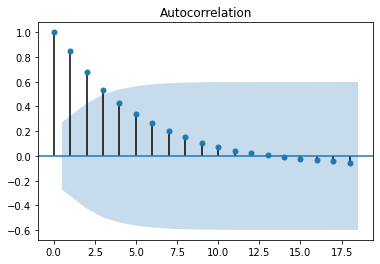

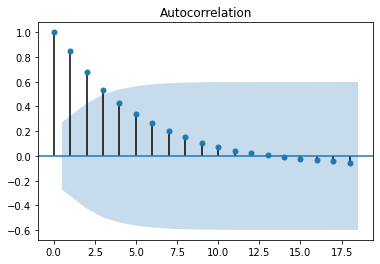

In [ ]:
plot_acf(data_arima)

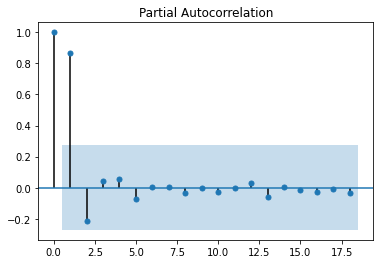

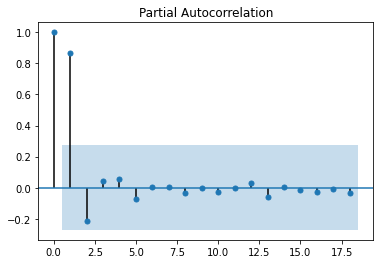

In [ ]:
plot_pacf(data_arima)

In [ ]:
## Spliting the Dataset into Train and Test
covid_train = data_arima[0:50].values.astype(np.float64)
covid_test = data_arima[50:52].values.astype(np.float64)
covid_train.size,covid_test.size

(50, 2)

In [ ]:
covid_test

array([[1314.],
       [1314.]])

In [ ]:
#Finding the best values for p,d,q for ARIMA Model

covid_model = ARIMA(covid_train,order=(0,1,1))

#fitting the model
# transparams=True, meaning the model should ensure for the stationary time series data
covid_model_fit = covid_model.fit(transparams=True) 

#printing the summary
covid_model_fit.summary(), covid_model_fit.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                              ARIMA Model Results                              
 Dep. Variable:                    D.y   No. Observations:                   49
 Model:                 ARIMA(0, 1, 1)   Log Likelihood                -247.226
 Method:                       css-mle   S.D. of innovations             37.092
 Date:                Fri, 03 Jul 2020   AIC                            500.452
 Time:                        20:51:53   BIC                            506.127
 Sample:                             1   HQIC                           502.605
                                                                               
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         25.0334      9.720      2.575      0.013       5.982      44.085
 ma.L1.D.y      0.8502      0.091      9.337      0.000       0.672   

In [ ]:
## Forecasting the covid cases for 2 future dates i.e. 22/03/2020 and 23/03/2020
covid_forecast = covid_model_fit.forecast(steps=2)[0] 


print("*"*50)
print("Actual Covid Cases for 22-03-2020:-",np.round(covid_test[0]))
print("Actual Covid Cases for 23-03-2020:-",np.round(covid_test[1]))
print("*"*50)

print("*"*50)
print("Predicted Covid Cases for 22-03-2020:-",np.round(covid_forecast[0]))
print("Predicted Covid Cases for 23-03-2020:-",np.round(covid_forecast[1]))
print("*"*50)


print("*"*50)
print("Root Mean Square Error:-",np.sqrt(mean_squared_error(covid_test,covid_forecast)))
print("*"*50)

**************************************************
Actual Covid Cases for 22-03-2020:- [1314.]
Actual Covid Cases for 23-03-2020:- [1314.]
**************************************************
**************************************************
Predicted Covid Cases for 22-03-2020:- 1275.0
Predicted Covid Cases for 23-03-2020:- 1300.0
**************************************************
**************************************************
Root Mean Square Error:- 29.711376639558353
**************************************************
